Smoke Sensor ID: 0xa16
FIFO samples 0
FIFO data 0xffff


<IPython.core.display.Javascript object>


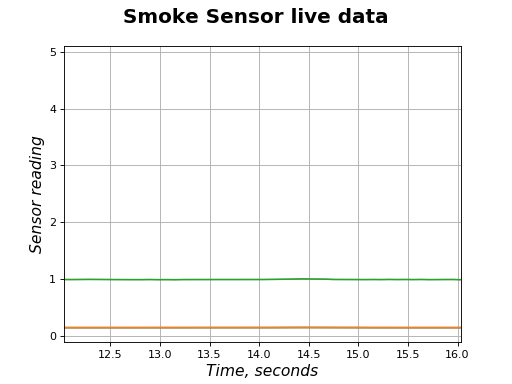

<IPython.core.display.Javascript object>


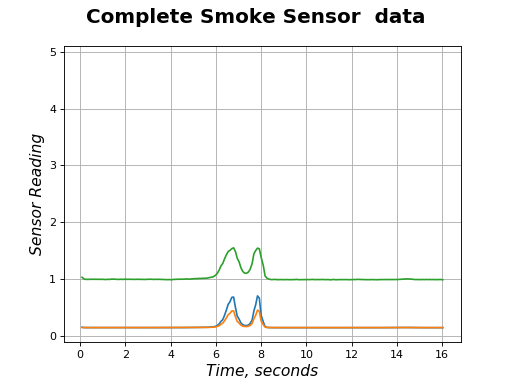

In [1]:
#
# AnalogMax: Smoke Sensor Demo
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
#
# Please change here to proper COM port name
#
ser = serial.Serial('COM5', 115200)
#
# ADPD register access functions
#
def ADPD_write_reg(reg, value):
    ser.reset_input_buffer() #
    cmd = "<c8K%0.2xK%0.2xK%0.2xK>" % (reg, (value >> 8), (value & 0xFF))  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value


def ADPD_read_reg(reg):
    ser.reset_input_buffer() #
    cmd = "<c8K%0.2xK<c9K..m..M>" % reg  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(4)
    return int(s, 16)
#
def ADPD_read_fifo():
    fifolevel = ADPD_read_reg(0x00) >> 8
    # Do something if fifo level < 2 ?
    retval = ADPD_read_reg(0x60)
    retval = 1.0 * retval/16384
    return retval
#
# ADPD register init from ADI Wavetool Application
# Filename: ADPD188BI_SK.dcfg
#
def ADPD_init_SK():
    ADPD_write_reg(0x00 ,0x1000)
    ADPD_write_reg(0x01 ,0xC0FF)
    ADPD_write_reg(0x02 ,0x0005)
    ADPD_write_reg(0x06 ,0x0F00)
    ADPD_write_reg(0x09 ,0x00C8)
    ADPD_write_reg(0x10 ,0x0000)
    ADPD_write_reg(0x11 ,0x30A9)
    ADPD_write_reg(0x12 ,0x0050)
    ADPD_write_reg(0x14 ,0x0117)
    ADPD_write_reg(0x15 ,0x0220)
    ADPD_write_reg(0x18 ,0x1F00)
    ADPD_write_reg(0x19 ,0x3FFF)
    ADPD_write_reg(0x1A ,0x3FFF)
    ADPD_write_reg(0x1B ,0x3FFF)
    ADPD_write_reg(0x1E ,0x1F00)
    ADPD_write_reg(0x1F ,0x3FFF)
    ADPD_write_reg(0x20 ,0x3FFF)
    ADPD_write_reg(0x21 ,0x3FFF)
    ADPD_write_reg(0x22 ,0x3531)
    ADPD_write_reg(0x23 ,0x3533)
    ADPD_write_reg(0x24 ,0x3531)
    ADPD_write_reg(0x25 ,0x6317)
    ADPD_write_reg(0x30 ,0x0319)
    ADPD_write_reg(0x31 ,0x0810)
    ADPD_write_reg(0x34 ,0x0000)
    ADPD_write_reg(0x35 ,0x0319)
    ADPD_write_reg(0x36 ,0x0810)
    ADPD_write_reg(0x38 ,0x0000)
    ADPD_write_reg(0x39 ,0x2203)
    ADPD_write_reg(0x3B ,0x2203)
    ADPD_write_reg(0x3C ,0x31C6)
    ADPD_write_reg(0x3E ,0x0320)
    ADPD_write_reg(0x3F ,0x0320)
    ADPD_write_reg(0x42 ,0x1C34)
    ADPD_write_reg(0x43 ,0xADA5)
    ADPD_write_reg(0x44 ,0x1C34)
    ADPD_write_reg(0x45 ,0xADA5)
    ADPD_write_reg(0x4B ,0x269C)
    ADPD_write_reg(0x4D ,0x0082)
    ADPD_write_reg(0x54 ,0x0AA0)
    ADPD_write_reg(0x58 ,0x0000)
    ADPD_write_reg(0x59 ,0x0808)
    ADPD_write_reg(0x5A ,0x0010)
    ADPD_write_reg(0x5E ,0x0808)
    ADPD_write_reg(0x5F ,0x0000)
    

def ADPD_init():
    ADPD_init_SK()
# Change one setting
    ADPD_write_reg(0x11 ,0x3065) # Channel A,B, Average, 16 bit sum of channels
# Enter normal mode
    ADPD_write_reg(0x10 ,0x0002)
   
    
    
ser.flushInput()
ser.reset_input_buffer() #
#
ser.write(b'[6]')    # Select UHSA I2C Channel
ser.reset_input_buffer() #

#
# Check sensor ID
#
id = ADPD_read_reg(0x08)
print("Smoke Sensor ID:", hex(id))
#
# "Normal" Register Init
# 
ADPD_init()


print("FIFO samples", ADPD_read_reg(0x00) >> 8)
print("FIFO data", hex(ADPD_read_reg(0x60)))

#
# Plot Sensor FIFO read data
#
plt.ion() 
start_time = time()
timepoints = []
xdata = []
ydata = []
zdata = []

yrange = [-0.1,5.1]
view_time = 4 # seconds of data to view at once
duration = 16 # total seconds to collect data

fig1 = plt.figure()
fig1.suptitle('Smoke Sensor live data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('Sensor reading', fontsize='14', fontstyle='italic')

line1, = plt.plot(xdata)
line2, = plt.plot(ydata)
line3, = plt.plot(zdata)

plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # Flush junk

run = True

# collect the data and plot a moving frame
while run:
    # 
    try:
        x = ADPD_read_fifo()
        # store the entire dataset for later
        xdata.append(x)

        y = ADPD_read_fifo()
        # store the entire dataset for later
        ydata.append(y)
        
        z = x/y
        zdata.append(z)

        
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints)
        line1.set_ydata(xdata)

        line2.set_xdata(timepoints)
        line2.set_ydata(ydata)
        
        line3.set_xdata(timepoints)
        line3.set_ydata(zdata)
        
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect+plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()
    
# plot all of the data you collected
fig2 = plt.figure()
fig2.suptitle('Complete Smoke Sensor  data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('Sensor Reading', fontsize='14', fontstyle='italic')

plt.plot(timepoints, xdata)
plt.plot(timepoints, ydata)
plt.plot(timepoints, zdata)
plt.ylim(yrange)
fig2.show()
#
# Blue LED will go off, also the GPIO0 LED
#
ADPD_write_reg(0x0F ,0x0001) # Issue Softreset

ser.close()
